In [30]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

sys.path.append(str(Path.cwd().parent / 'scripts'))

from build_wholesale_prices import get_extremes, get_price_distribution

In [3]:
path = Path.cwd().parent / 'data' / 'base'

In [24]:
bids = []
offers = []
pns = []
dah = []

for d in tqdm(os.listdir(path)):

    try:
        bids.append(
            pd.read_csv(path / d / 'bids.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        offers.append(
            pd.read_csv(path / d / 'offers.csv', index_col=[0,1]
            )
        )
    except FileNotFoundError:
        pass

    try:
        pns.append(
            pd.read_csv(path / d / 'physical_notifications.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass

    try:
        dah.append(
            pd.read_csv(path / d / 'day_ahead_prices.csv', index_col=0
            )
        )
    except FileNotFoundError:
        pass


offers = pd.concat(offers)
bids = pd.concat(bids)
pns = pd.concat(pns)
dah = pd.concat(dah)

100%|██████████| 851/851 [00:51<00:00, 16.46it/s]


In [128]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'bmus_prepared.csv', index_col=0)
h = bmus.loc[bmus['carrier'] == 'hydro'].index

bidding_h = h.intersection(bids.columns)
offering_h = h.intersection(offers.columns)

In [62]:
idx = pd.IndexSlice

o = offers.loc[idx[:, 'price'], offering_h].std().sort_values(ascending=True)
o

LCSMH-1        0.000000
FASN-1        78.365161
CAS-GAR01     89.352801
FASN2         97.449252
CAS-KIL01    102.124661
GLNDO-1      102.327558
SLOY-4       105.237621
FASN3        107.684510
SLOY-3       109.949890
NANT-1       130.021871
ERRO-1       141.952180
SLOY-2       145.987576
SLOY-1       148.744301
ERRO-2       150.182155
FINL-1       150.334757
CLAC-1       154.325696
ERRO-3       157.884102
RHEI-4       615.616811
dtype: float64

In [76]:

b = bids.loc[idx[:, 'price'], bidding_h].std().sort_values(ascending=True)
plot_bids = bids.copy().loc[idx[:, 'price'], :]
plot_bids.index = plot_bids.index.droplevel(1)
plot_bids.index = pd.to_datetime(plot_bids.index)
b

FASN-4        0.000000
CAS-CLU01    11.533848
CAS-MOR01    19.309559
LCSMH-1      20.666877
CAS-KIL01    30.158900
CAS-GAR01    31.065319
CAS-BEU01    35.621446
SLOY-4       36.147601
ERRO-1       37.053834
ERRO-2       38.026695
CAS-CON01    40.177711
ERRO-3       41.050082
SLOY-3       42.679298
CLAC-1       45.635594
GLNDO-1      49.563479
NANT-1       49.853070
FASN3        52.120279
SLOY-2       52.248106
FASN2        52.288455
SLOY-1       52.385861
FINL-1       55.273885
FASN-1       56.284019
RHEI-4       90.824604
dtype: float64

In [106]:
wind = bmus.loc[bmus['carrier'] == 'onwind'].index

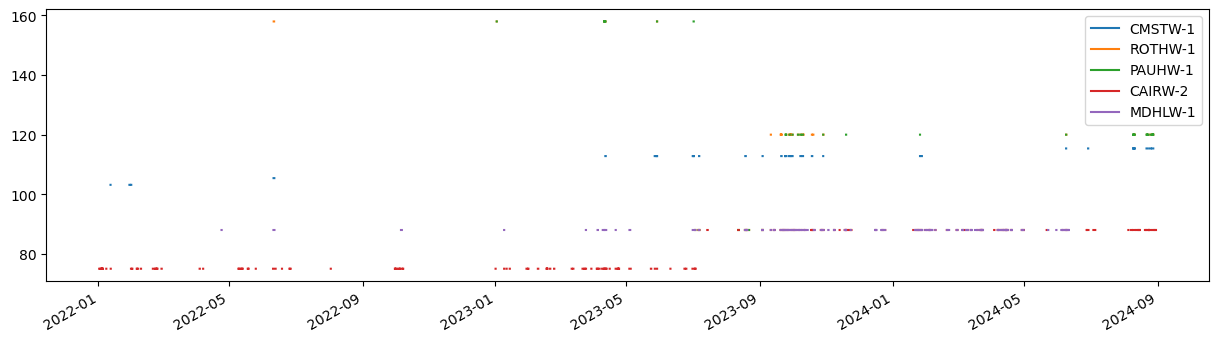

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 4))
# bids.loc[idx[:, 'price'], b.index[-6:]].plot(ax=ax)

plot_bids.loc[
    :,
    wind.intersection(plot_bids.columns)[:5],
    ].plot(ax=ax)

plt.show()

<Axes: >

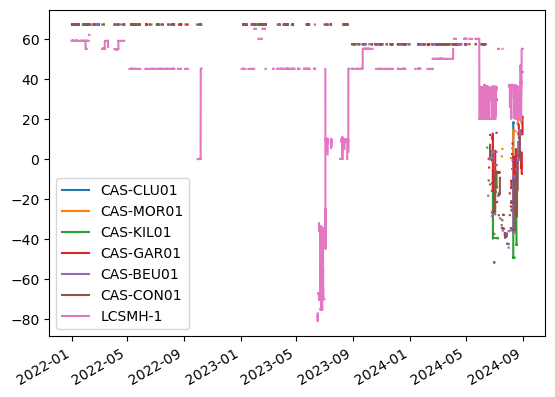

In [113]:
cas = b.index[b.index.str.contains('CAS')].to_list() + ['LCSMH-1']
non_cas = b.index[~b.index.str.contains('CAS')].to_list()
non_cas.remove('LCSMH-1')

plot_bids.loc[
    :,#pd.Timestamp('2023-05-22', tz='utc'):pd.Timestamp('2023-05-25', tz='utc'),
    # ['CAS-MOR01']
    cas
    # non_cas
    # ['ERRO-2', 'ERRO-3'] 
    ].plot()

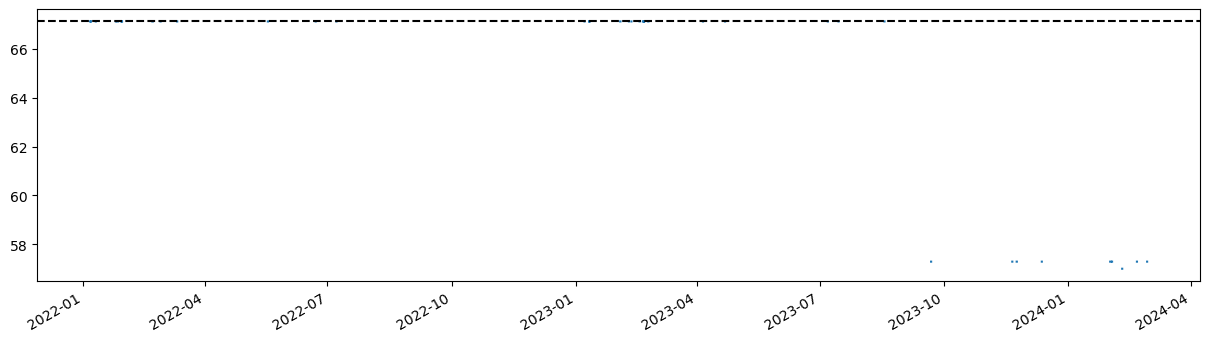

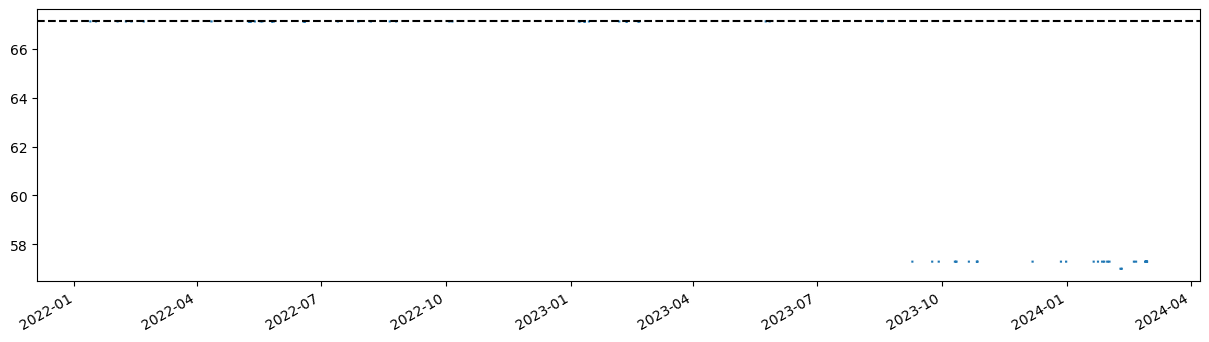

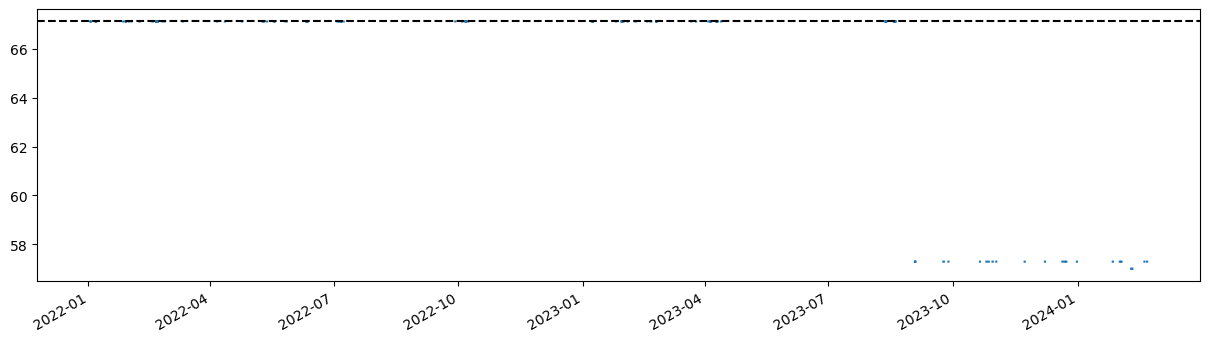

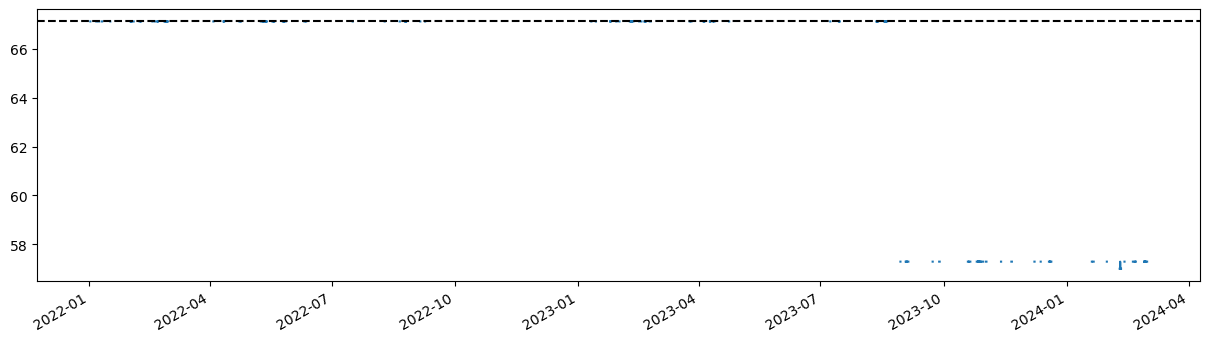

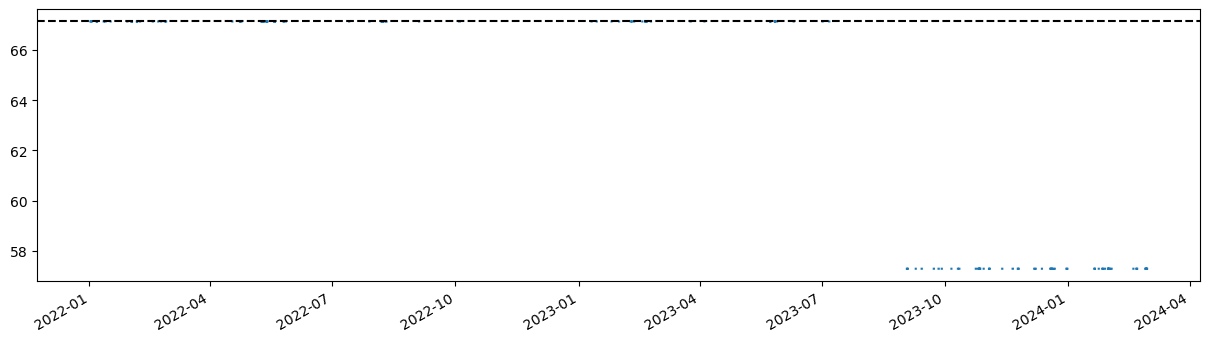

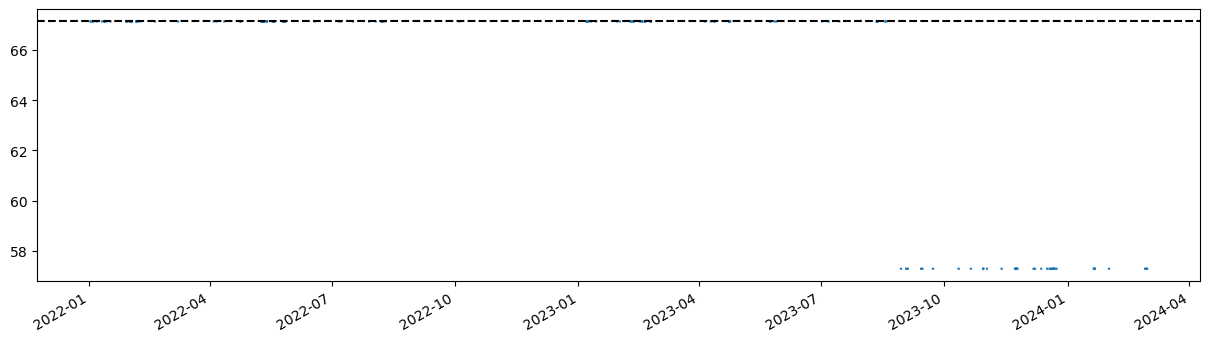

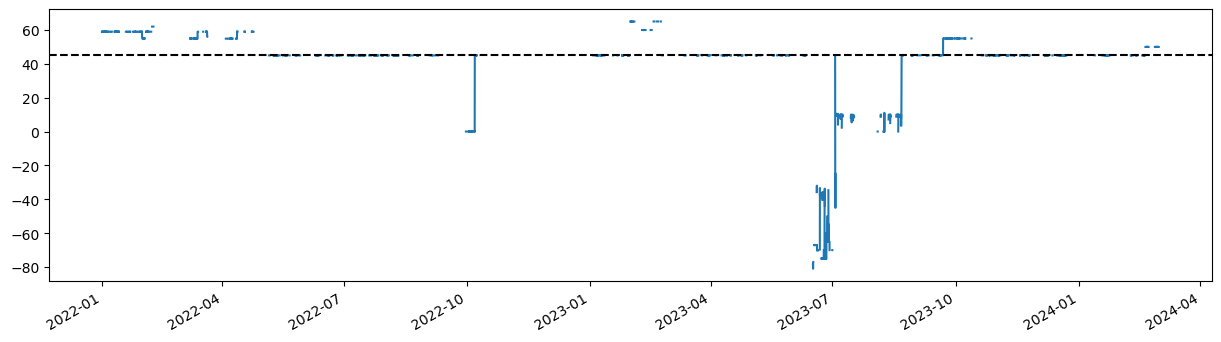

CAS-CLU01    67.13
CAS-MOR01    67.13
CAS-KIL01    67.13
CAS-GAR01    67.13
CAS-BEU01    67.13
CAS-CON01    67.13
LCSMH-1      44.95
dtype: float64


In [143]:
def build_cascading_roc_prices(bids, name):
    
    end_date = pd.Timestamp('2024-03-01', tz='utc')
    bids = bids.copy().loc[:end_date, name]

    roc_value = bids.value_counts().index[0]

    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    bids.plot(ax=ax)
    ax.axhline(roc_value, color='k', linestyle='--')
    plt.show()

    return roc_value

roc_values = pd.Series(
    {name: build_cascading_roc_prices(plot_bids, name) for name in cas}
)

# build_cascading_roc_prices(plot_bids, 'CAS-MOR01')
# build_cascading_roc_prices(plot_bids, 'LCSMH-1')

print(roc_values)

In [ ]:
# pns.index = pd.to_datetime(pns.index)

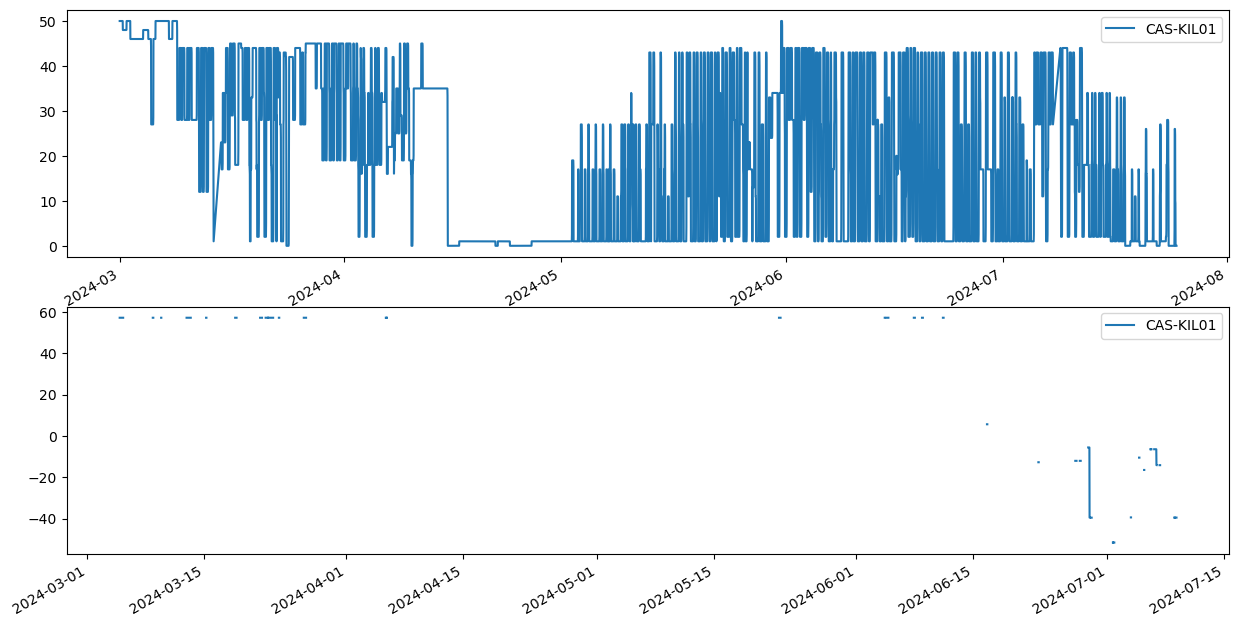

In [119]:
start, end = pd.Timestamp('2024-03-01', tz='utc'), pd.Timestamp('2024-07-25', tz='utc')

fig, ax = plt.subplots(2, 1, figsize=(15, 8))

# index = cas
index = ['CAS-KIL01']
pns[index].loc[start:end].plot(ax=ax[0])
plot_bids[index].loc[start:end].plot(ax=ax[1])

plt.show()

# pns[h].iloc[:500].plot()
# pns['CAS-CLU01'].iloc[1000:2000].plot()
# pns[non_cas].iloc[1000:2000].plot(ax=ax)
# pns['LCSMH-1'].iloc[1000:2000].plot()

In [129]:
bmus.loc[bmus['carrier'] == 'cascade'].index

Index(['LCSMH-1', 'CAS-BEU01', 'CAS-CLU01', 'CAS-CON01', 'CAS-GAR01',
       'CAS-KIL01', 'CAS-MOR01'],
      dtype='object', name='NationalGridBmUnit')

##### Building available generation for hydro and cascade per day

c:\Users\lukas\OneDrive\Desktop\projects\nodal\UKLMP\data\base\2024-03-01\physical_notifications.csv


<Axes: >

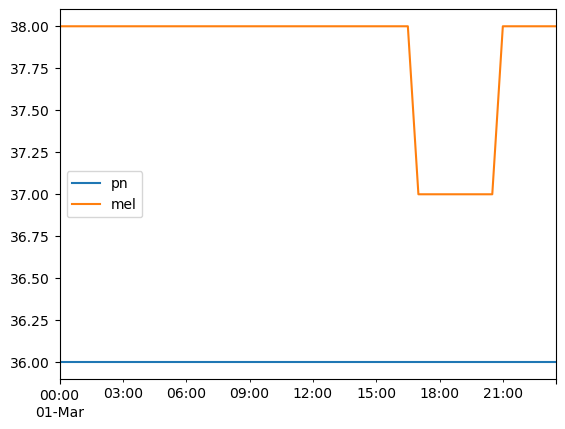

In [149]:
path = Path.cwd().parent / 'data' / 'base'

mock = {
    'pn': str(path / '{}' / 'physical_notifications.csv'),
    'mel': str(path / '{}' / 'maximum_export_limits.csv'),
}

print(mock['pn'].format('2024-03-01'))

def get_generation_volume(name, day):

    pn = (
        pd.read_csv(mock['pn'].format(day), index_col=0, parse_dates=True)
        .rename(columns={name: 'pn'})['pn']
    )
    mel = (
        pd.read_csv(mock['mel'].format(day), index_col=0, parse_dates=True)
        .rename(columns={name: 'mel'})['mel']
    )

    return pn, mel


pd.concat(get_generation_volume('CAS-GAR01', '2024-03-01'), axis=1).plot()

<Axes: >

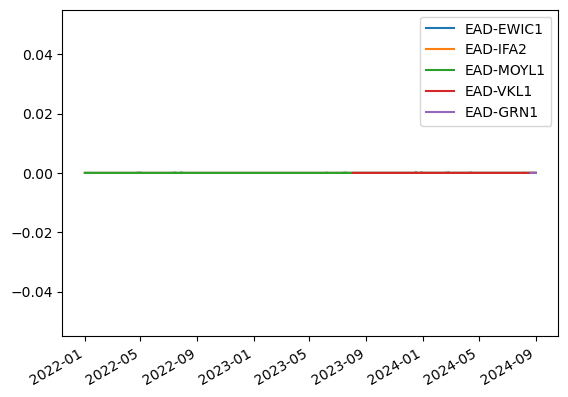

In [158]:
# pns[pns.columns[pns.columns.str.contains('NEMO')]].plot()
# pns['IND-ALIP1'].plot()
pns[pns.columns[pns.columns.str.startswith('EAD')]].plot()

In [1]:
'''
I need a snakemake rule that has a wildcard 'day' in its output
As a an input wildcard it should have the respective week-of-the-year.
It should identify which week the day corresponds to using a lambda function
'''

"\nI need a snakemake rule that has a wildcard 'day' in its output\nAs a an input wildcard it should have the respective week-of-the-year.\nIt should identify which week the day corresponds to using a lambda function\n"